In [36]:
%matplotlib inline
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# DB = os.environ.get('DB', '../db.sqlite')
DB = os.environ.get('DB', '../db_preprocessed.sqlite')
db = sqlite3.connect(DB)
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
cur = db.cursor()

from matplotlib import rc
import matplotlib.pylab as plt
rc('font', **{'family': 'sans-serif'})
rc('text', usetex=False)

# General info about dataset

In [2]:
md5sums = pd.read_csv('../db_preprocessed/md5sum.dsv', sep=' ', usecols=[0,2], header=None)
md5vals = md5sums[0].value_counts()
print(f'There are {len(md5sums)} tables, {len(md5vals)} unique tables, and {sum(md5vals>1)} tables that occur mor than once')
for val in md5vals.index[:10]:
    print(val, md5vals[val], next(iter(md5sums[md5sums[0] == val][2])))

There are 1535332 tables, 1426303 unique tables, and 26260 tables that occur mor than once
d4482633b2e3bb69d8e97066c1aca09b 24969 ./3696399-1.csv
afb8a5bbe2d986de3e508644d145436a 6113 ./12197304-1.csv
f57ae4228f6d3233333b580c2206776d 2584 ./40016920-143.csv
d2f43ffada25942844fc70bbb43aa568 987 ./40016920-1433.csv
71a8983a2d929cb406109eecaa0a22e2 980 ./35091166-4.csv
f8455c6606bfbc601e87472686953608 690 ./3790400-1.csv
845d517d0992aff6367a4d280c8df797 562 ./3797222-1.csv
80e317c222fdf8ebb05d7cffa80661af 519 ./36593008-1.csv
a40c7519c0f63b2301f356f906337c50 377 ./40016920-1435.csv
70f088c976ed211b5ea4c24dbba30b25 224 ./5767475-1.csv


In [3]:
df = pd.read_sql('SELECT (SUM(numHeaderRows)*1.0 / COUNT(*)*1.0) AS mean_header_rows FROM tables WHERE numHeaderRows > 0', db)
df

mean_header_rows
0          1.082333

In [4]:
df = pd.read_sql('SELECT (SUM(numDataRows)*1.0 / COUNT(*)*1.0) AS mean_body_rows FROM tables', db)
df

mean_body_rows
0       11.305544

In [5]:
df = pd.read_sql('SELECT (SUM(numCols)*1.0 / COUNT(*)*1.0) AS mean_cols FROM tables', db)
df

mean_cols
0   5.350528

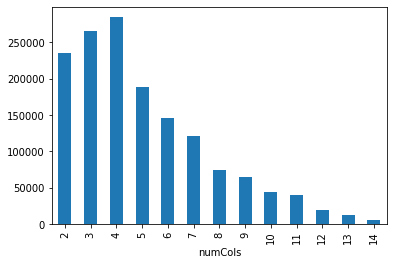

In [6]:
df = pd.read_sql('SELECT numCols, COUNT(*) AS n FROM tables GROUP BY numCols', db)
df[(df['numCols'] > 1) & (df['numCols'] < 15)].set_index('numCols')['n'].plot.bar()

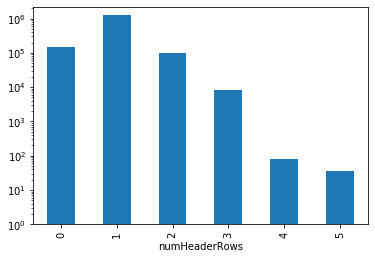

In [7]:
df = pd.read_sql('SELECT numHeaderRows, COUNT(*) AS n FROM tables GROUP BY numHeaderRows', db)
df = df.set_index('numHeaderRows')
df[(df['n']>10)]['n'].plot.bar(logy=True, ylim=(1,None))

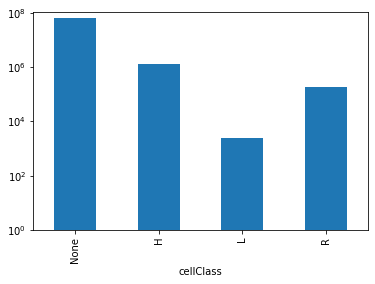

In [8]:
df = pd.read_sql('SELECT cellClass, COUNT(*) AS n FROM cells GROUP BY cellClass', db)
df.set_index('cellClass')['n'].plot.bar(logy=True, ylim=(1,None))

In [9]:
pd.read_sql('SELECT cellClass, COUNT(*) AS n FROM cells GROUP BY cellClass', db)

cellClass         n
0      None  63440920
1         H   1308629
2         L      2507
3         R    179699

In [10]:
pd.read_sql("""
WITH preprocessed AS (SELECT DISTINCT pgId, tbNr FROM cells WHERE cellClass IS NOT NULL)
SELECT COUNT(*) AS c FROM preprocessed
""", db)

c
0  143574

# Numbers for headers

In [11]:
df = pd.read_sql('SELECT COUNT(*) AS n_tables_with_header FROM tables WHERE numHeaderRows > 0', db)
df

n_tables_with_header
0               1390942

In [12]:
cur.execute("SELECT COUNT(DISTINCT headerId) AS c FROM tables").fetchone()['c']

330221

In [13]:
%%time 
df = pd.read_sql("SELECT headerId, COUNT(*) AS c FROM tables GROUP BY headerId ORDER BY c DESC", db)
df['i'] = df.index

CPU times: user 1.43 s, sys: 96 ms, total: 1.52 s
Wall time: 1.53 s


In [14]:
h = df.head(10).copy()
q = "SELECT group_concat(cellText, '|') AS header FROM headers WHERE headerId=? AND row=0 ORDER BY col"
h['header'] = [cur.execute(q,[i]).fetchone()['header'] for i in h['headerId']]
h

headerId      c  i                                    header
0  1111143432686705088  66450  0                             source|rating
1  1657868244709389437  64510  1                                      None
2  7326066013829363814  54389  2                                      None
3  6952567387912792180  12903  3                                         |
4  8695534584841744624  11369  4  type|name|title|royal house|from|to|refs
5  4999464515008764016  10791  5                     year|title|role|notes
6  5898763631062762217   7993  6               team|pld|w|d|l|gf|ga|gd|pts
7  8079303172401881444   7034  7                             1|2|3|4|total
8  4200412907700439156   5880  8                  event|gold|silver|bronze
9  2133525050809446293   5850  9                                      None

In [15]:
print(f'There are {sum(df["c"] == 1)} / {len(df)} headers that occur once (= {sum(df["c"] == 1)/len(df):.2f})')
print(f'{len(df) - sum(df["c"] == 1)} headers repeat')
df['c'].value_counts().head()

There are 247403 / 330221 headers that occur once (= 0.75)
82818 headers repeat


1    247403
2     34363
3     12956
4      7624
5      4561
Name: c, dtype: int64

In [16]:
pd.read_sql("""
WITH headerCounts AS (SELECT headerId, COUNT(*) AS c FROM tables GROUP BY headerId)
SELECT COUNT(*) AS nHeaders, SUM(c) AS nTables FROM headerCounts WHERE c > 1
""", db)

nHeaders  nTables
0     82818  1287929